## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser.

----

This notebook performs Bayesian Optimizaion using GPytorch of the Lund string model parameters that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{1}{z^{1+r_Q b m_Q^2}}(1-z)^{a'_i} \exp \left(-\frac{b m_{\perp}^2}{z}\right),
$$

As well as other important flavor and shower parameters. For detailed description of these parameters, see my overleaf writeup.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

In [292]:
import numpy as np
from scipy.stats import qmc
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [259]:
MAX_PROB = 4.0
PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        'StringZ:rFactC':[0.0, 2.0],
        'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        'StringPT:enhancedWidth':[1.0,MAX_PROB],
        'StringFlav:ProbStoUD':[0,MAX_PROB],
        'StringFlav:probQQtoQ':[0,MAX_PROB],
        'StringFlav:probSQtoQQ':[0,MAX_PROB],
        'StringFlav:ProbQQ1toQQ0':[0,MAX_PROB],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "aExtraSQuark": 0.0,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}


def get_param_prefix(param):
    for key,val in PARAM_DICT.items():
        prefix, postfix = key.split(':')
        if postfix == str(param):
            return prefix

param_names = list(PARAM_DICT.keys())
print(len(PARAM_DICT))

15


## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

We use the following test statistic
$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2},
$$
where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

In [72]:
def make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 2500          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        f.write(f"StringZ:rFactC = {rFactC}\n\n")
        f.write(f"StringZ:rFactB = {rFactB}\n\n")
        f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        f.write(f"StringZ:aExtraDiquark = {aExtraDiquark}\n\n")
        f.write(f"StringPT:sigma = {sigma}\n\n")
        f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        f.write(f"StringPT:enhancedWidth = {enhancedWidth}\n\n")
        f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        f.write(f"StringFlav:ProbQQ1toQQ0 = {ProbQQ1toQQ0}\n\n")
        f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [5]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [6]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
            
    objective_func = X0[0]
        
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

## Gaussian Process Regression

A data set $\mathcal{D}= \left\{ \mathbf{x}, \mathbf{y} \right\} = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

The assumption is that the actual observations are a noise-corrupted value of the true model:
$$
y = f(x) + \varepsilon, \tag{1}
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise. FOr example, the model could be $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}$.  

In general, the posterior predictive distribution marginalizes over the model parameters $w$:

$$ p(y \mid x, \mathcal{D}) = \int p(y, w \mid x, \mathcal{D}) d w = \int p(y \mid x, w) p(w \mid \mathcal{D}) dw \tag{2}$$

Using Eq. (1), one can write the likelihood, which is Gaussian

$$p(y \mid w) = p(y \mid x, w) = \mathcal{N}(y; f(x), \sigma^2)$$

However, the integral in Eq. (1) is intractable in closed form. The trick is realizing that the first term in Eq. (1) is a Gaussian. Furthermore, $p(w \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid w) p(w)}{Z}$ is a product of Gaussians normalized by a Gaussian, so it is also a Gaussian, therefore, $p(y \mid x, \mathcal{D}) $ is a Gaussian.


$p(\mathbf{y}\mid\mathbf{x})$ is thus fully specified by the Kernel, and it starts out being the Gaussian process prior
$$ p(y_1, ... y_n \mid x_1, .., x_n)  = \mathcal{N}(y;0, \Sigma) \tag{3}$$ 
Where, $\Sigma$ can be decomposed as

$$ \Sigma =  \begin{pmatrix}
k & k_* \\
k_*^T & k_{**}
\end{pmatrix} $$

Another way to write Eq. (3) is
$$ \left[\begin{array}{c}
f\left(x^*\right) \\
f\left(x_1\right) \\
\vdots \\
f\left(x_n\right)
\end{array}\right] \sim N\left(\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0
\end{array}\right],\left[\begin{array}{cc}
k\left(x^*, x^*\right) & k\left(x^*, \mathbf{x}\right)^T \\
k\left(x^*, \mathbf{x}\right) & K_{\mathbf{x x}}
\end{array}\right]\right)$$


where the the kernel components $k$'s are functions of $x_1,...,x_n$ and $x_*$
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$

The most commonly used kernel is the RBF kernel  $\Sigma_{x,y} = k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  There is usually a multiplicative constant in front which controls the amplitude, and can be accessed with `ScaleKernel(RBFKernel())`

Now, given a new data point $x^*$, $y^*$ can be predicted with
$$
y_* | \mathcal{D}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)), \tag{4}
$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$

$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$



In [204]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=train_x.size(-1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

A rule of thumb is to choose the training set size to be 10-20 times the number of parameters. This gives us 150-300 examples.

In [260]:
SUBSAMPLE = -1
train_df = pd.read_csv('LHS_DF_with_chi2.csv')[:SUBSAMPLE]
# train_df = pd.read_csv('ALL_PRAMS_DF_with_chi2.csv')
train_df.head()

,Unnamed: 0.1,Unnamed: 0,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
0,2,2,1.018815,1.907645,0.593628,1.285956,0.469747,0.616684,0.321632,0.093016,3.353963,2.502734,1.611805,3.728123,3.530520,0.150097,1.086739,38.989016
1,3,3,0.988716,0.471020,1.764055,0.462788,1.921271,0.872170,0.855325,0.969504,1.399415,3.818593,1.148781,2.588958,2.094627,0.114196,1.930516,40.164803
2,4,4,0.444193,1.834390,0.123916,1.964130,0.733800,1.430367,0.223075,0.812724,2.754028,3.016335,0.074418,0.043306,2.476595,0.100424,1.358620,29.317393
3,8,8,0.463673,1.647624,1.484369,0.706367,1.915505,1.579792,0.026979,0.088789,2.203874,3.153978,2.098117,0.935123,0.565346,0.126309,0.828173,42.062218
4,9,9,1.034734,1.489235,0.438249,0.517065,0.490425,1.223198,0.590138,0.841279,3.643448,3.529870,0.183085,1.555951,0.421221,0.160989,1.183123,39.716942


In [257]:
train_df.describe()

,Unnamed: 0.1,Unnamed: 0,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,2474.600559,2474.600559,0.967550,1.150754,0.984285,0.976983,1.014280,0.973088,0.557530,0.520665,2.557065,1.943075,1.998245,1.982008,1.986946,0.123908,1.153417,39.617433
std,1407.228210,1407.228210,0.574628,0.515264,0.577392,0.580295,0.577936,0.579404,0.284337,0.289044,0.878386,1.179048,1.164232,1.150876,1.157153,0.048832,0.513942,8.754827
min,2.000000,2.000000,0.000757,0.200019,0.001319,0.000595,0.001198,0.000066,0.002492,0.000720,1.002470,0.001232,0.001278,0.001533,0.003851,0.060011,0.100453,5.622573
25%,1237.500000,1237.500000,0.456235,0.716932,0.485317,0.474782,0.525525,0.473873,0.318254,0.276856,1.802306,0.895631,1.003590,0.984325,0.991808,0.084033,0.748500,35.537392
50%,2497.500000,2497.500000,0.960681,1.170419,0.984158,0.963313,1.014947,0.972272,0.590155,0.529974,2.558531,1.940536,2.025128,1.992738,1.995830,0.112906,1.188820,40.322606
75%,3738.500000,3738.500000,1.449723,1.593148,1.472815,1.481971,1.509191,1.476332,0.805902,0.778022,3.319240,2.950523,3.007061,2.977555,2.998031,0.150211,1.590690,44.400032
max,4966.000000,4966.000000,1.999840,1.999032,1.998945,1.999374,1.999794,1.999412,0.999744,0.999888,3.999811,3.999675,3.998602,3.998643,3.994812,0.249931,1.999538,72.316498


In [270]:
train_x = train_df[param_names].to_numpy()
train_y = train_df['chi2'].to_numpy()

In [271]:
train_x.shape

(2148, 15)

In [272]:
train_y.shape

(2148,)

### Make new dataset here in jupyter

In [154]:
def make_train_dataset(PARAM_DICT, points):
    param_names = list(PARAM_DICT.keys())
    column_names = param_names + ['chi2']
    
    rows = []
    for _ in range(points):
        row = []
        for param_name, range_ in PARAM_DICT.items():
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            row.append(uniform_size_1)
        
        chi2 = true_objective_func(*row)
        row.append(chi2)
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=column_names)
    return df

In [107]:
train_df_new = make_train_dataset(PARAM_DICT, 75)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Traceback (most recent call last):
  File "/usr/local/bin/rivet", line 213, in <module>
    all_analyses = rivet.AnalysisLoader.analysisNames() #< excludes aliases
KeyboardInterrupt


[0]
looping over 1 sim yoda files...



  0%|                                                     | 0/1 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


FileNotFoundError: ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

In [499]:
train_df_new.describe()

,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,1.024165,1.054585,1.084380,0.991521,0.911402,1.187171,0.490522,0.415595,2.509142,1.991589,2.035131,1.934464,1.983899,0.162765,0.980156,39.612894
std,0.574277,0.583546,0.600075,0.565680,0.518722,0.544235,0.277581,0.267377,0.893851,1.122669,1.258252,1.118541,1.089561,0.056914,0.520526,10.400232
min,0.023940,0.011581,0.009009,0.050850,0.072157,0.104720,0.003080,0.014562,1.047797,0.019426,0.077434,0.072592,0.063163,0.062414,0.112414,12.094384
25%,0.513596,0.582569,0.496514,0.488645,0.478093,0.775668,0.244520,0.196665,1.646296,1.045230,0.859674,1.091707,0.982966,0.104994,0.502800,33.589837
50%,1.051557,1.028745,1.090294,0.934820,0.937415,1.339954,0.486186,0.404398,2.444228,1.939143,2.189786,1.724426,2.084855,0.178182,0.959600,38.086453
75%,1.524026,1.650432,1.588286,1.475464,1.284238,1.604564,0.755765,0.575821,3.420676,3.015661,3.187998,2.881929,2.903214,0.209231,1.298491,44.197712
max,1.994026,1.918090,1.996329,1.998909,1.983874,1.999732,0.987084,0.993511,3.988504,3.985817,3.866482,3.942006,3.824085,0.247729,1.967896,72.540827


In [155]:
train_x = train_df_new[param_names].to_numpy()
train_y = train_df_new['chi2'].to_numpy()
train_x.shape

NameError: name 'train_df_new' is not defined

## Define model and likelihood

In [273]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood).double()

In [274]:
model.train_targets

tensor([38.9890, 40.1648, 29.3174,  ..., 25.2538, 44.1468, 32.4546],
       dtype=torch.float64)

In [275]:
model.train_inputs[0].shape

torch.Size([2148, 15])

In [358]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        self.min = PARAM_DICT[pre_postfix][0]
        self.max = PARAM_DICT[pre_postfix][1]
        
    def uniform(self):
        return torch.tensor(np.random.uniform(
                low=self.min,
                high=self.max,
                size=self.size))

    def linspace(self):
        return torch.linspace(start=self.min,
                end=self.max,
                steps=self.size)

    def scale_sample(self, sample):
        return sample * (self.max - self.min) + self.min

In [362]:
def make_sobol_candidates(PARAM_DICT, size):
    num_params = len(PARAM_DICT)
    
    # Create a single Sobol sampler for all dimensions
    sampler = qmc.Sobol(d=num_params, scramble=True)
    
    # Generate samples
    samples = sampler.random(n=size)
    
    # Scale samples for each parameter
    scaled_samples = np.empty_like(samples)
    for ind, (key, val) in enumerate(PARAM_DICT.items()):
        param_name, range_ = key, val
        param_postfix = param_name.split(':')[1]
        param_sampler = Sample_param(param=param_postfix, size=size)
        scaled_samples[:, ind] = param_sampler.scale_sample(samples[:, ind])
    
    return torch.tensor(scaled_samples)


In [363]:
make_sobol_candidates(PARAM_DICT,1000)[:,1].min()

tensor(0.2012, dtype=torch.float64)

In [364]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates[0])

tensor([0.2806, 1.2366, 0.7788, 0.5997, 1.6582, 0.3003, 0.6780, 0.1622, 1.0676,
        1.5605, 0.2595, 2.3369, 2.4335, 0.1495, 0.2951], dtype=torch.float64)


In [365]:
x_candidates_aLund =x_candidates[:,0]
print(x_candidates_aLund)

tensor([0.2806, 0.4931], dtype=torch.float64)


In [366]:
def compare_uniform_sobol(PARAM_DICT,size):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    uniform_candidates = make_x_candidates(PARAM_DICT,size)
    a_uniform = uniform_candidates[:,0]
    b_uniform = uniform_candidates[:,1]
    ax[0].scatter(a_uniform, b_uniform)
    ax[0].set_title('Uniform MC')
    
    sobol_candidates = make_sobol_candidates(PARAM_DICT,size)
    a_sobol=sobol_candidates[:,0]
    b_sobol=sobol_candidates[:,1]
    ax[1].scatter(a_sobol, b_sobol)
    ax[1].set_title('Sobol')
    
    for i in range(2):
        ax[i].set_xlabel('aLund')
        ax[i].set_ylabel('bLund')
    plt.show()

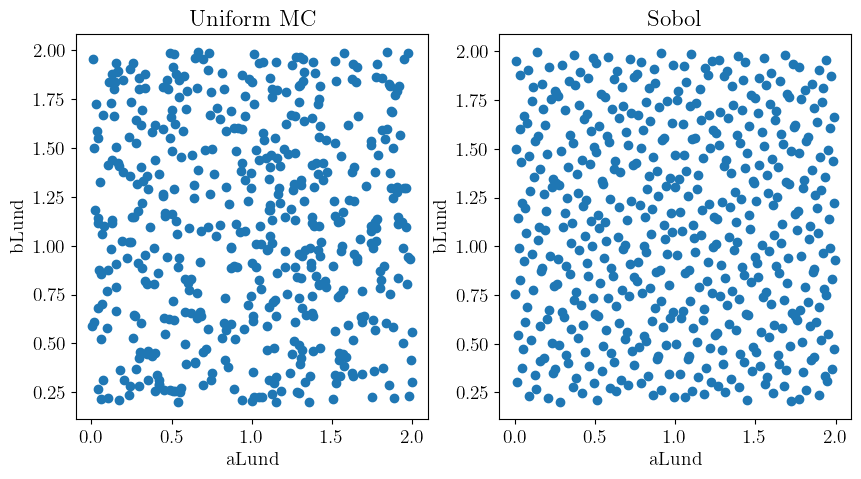

In [367]:
compare_uniform_sobol(PARAM_DICT,500)

In [114]:
# make sure you can call model on x_candidates
model.predict(x_candidates)

MultivariateNormal(loc: torch.Size([2]))

In [115]:
def make_multidim_xstar(param,size):

    x_star0 = Sample_param(param,size).linspace()
    # empty = np.ones((size,15))
    empty = make_x_candidates(PARAM_DICT, size)
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)
    empty[:,param_index] = x_star0
    # print(empty)
    return torch.tensor(empty)

In [46]:
x_star = make_multidim_xstar(param='bLund',size=2)
x_star

tensor([[0.9797, 0.0000, 0.0148, 1.4553, 1.9253, 0.5849, 0.9568, 0.7193, 3.0000,
         3.1433, 0.0623, 1.2253, 3.4724, 0.1866, 1.2545],
        [1.1304, 2.0000, 0.8413, 1.8133, 1.6556, 1.0791, 0.2290, 0.4002, 1.5527,
         0.6985, 3.7140, 1.3928, 2.8092, 0.1325, 1.6447]], dtype=torch.float64)


/tmp/ipykernel_133/201385255.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


tensor([[0.9797, 0.0000, 0.0148, 1.4553, 1.9253, 0.5849, 0.9568, 0.7193, 3.0000,
         3.1433, 0.0623, 1.2253, 3.4724, 0.1866, 1.2545],
        [1.1304, 2.0000, 0.8413, 1.8133, 1.6556, 1.0791, 0.2290, 0.4002, 1.5527,
         0.6985, 3.7140, 1.3928, 2.8092, 0.1325, 1.6447]], dtype=torch.float64)

In [47]:
train_x_model = model.train_inputs[0].numpy()
train_x_model[:,0]

array([1.01881549e+00, 9.88716358e-01, 4.44192990e-01, 4.63673109e-01,
       1.03473371e+00, 1.70485354e-01, 9.27209456e-01, 2.93858918e-01,
       4.27706582e-01, 2.54204793e-01, 3.45771454e-01, 8.58326001e-02,
       1.27607851e+00, 6.79710521e-01, 1.79812334e+00, 4.34989779e-01,
       4.68250267e-01, 1.39564913e+00, 4.38279336e-01, 1.80868595e+00,
       1.50836523e+00, 6.12705831e-02, 1.48420302e+00, 1.65142292e-03,
       1.76196768e+00, 1.65187139e+00, 1.39743873e+00, 1.50615062e-01,
       1.87999982e+00, 3.55688322e-01, 1.79152473e+00, 9.37057911e-01,
       1.37357437e+00, 6.37222925e-01, 8.27547039e-01, 1.24950000e+00,
       3.36695353e-01, 1.98487607e+00, 6.67309484e-01, 9.43246885e-01,
       9.51081477e-01, 1.04418954e+00, 7.57046479e-04, 4.01768062e-01,
       7.92529021e-01, 1.70369914e+00, 1.67196117e-01, 4.51276464e-01,
       1.87077329e+00, 2.55213170e-01, 1.93840604e+00, 1.09359472e+00,
       2.04551344e-01, 1.78221238e+00, 1.95366832e+00, 1.31711191e+00,
      

In [266]:
def plot_model_param(model,param):
    train_x = model.train_inputs[0].numpy()
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)

    train_x_param = train_x[:,param_index]
    train_y = model.train_targets.numpy()
    
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 200)
    else:
        # x_star = make_x_candidates(PARAM_DICT,200)
        x_star  = make_multidim_xstar(param,200)
        
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()
    
    print(pred.shape)

    x_star_param =x_star[:,param_index].numpy()
    plt.plot(x_star_param, pred, label='Mean Prediction', color='red')
    plt.fill_between(x_star_param, lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x_param, train_y, 'k*', label='Observed Data', alpha=0.5)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel(r'$\lambda$')
    plt.show()

/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


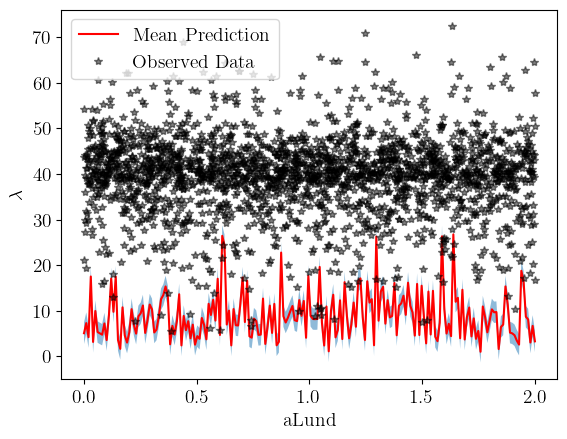

In [267]:
plot_model_param(model, 'aLund')

### Redefine model with reduced training data

In [276]:
mask = train_y < 8
train_y = train_y[mask]
train_x = train_x[mask]

likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood).double()
print(train_x.shape)

torch.Size([7, 15])


/tmp/ipykernel_133/3897308452.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(train_x)
/tmp/ipykernel_133/3897308452.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y)


### Observe untrained (default) GP model parameters

In [277]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [278]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(0., dtype=torch.float64)
covar_module.raw_outputscale tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


## Tune hyperparameters of GP model (train model)

We tune the hyperparameters by maximizing the marginal log likelihood (MLL) (i.e. treating -MLL as the loss and minimizing it)

$$ \text{MLL} = p_f(\mathbf{y} \mid \mathbf{X})=\int p(\mathbf{y} \mid f(\mathbf{X})) p(f(\mathbf{X}) \mid \mathbf{X}) d f $$

$$ \mathcal{L}= - \text{MLL}$$

In [279]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
        if print_:
                print('Epoch %d/%d - Loss: %.3f   lengthscale: %s   noise: %.3f\n' % (
        epoch + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.tolist()[0],
        model.likelihood.noise.item()
    ))
        loss.backward()
        optimizer.step()

In [280]:
train_model(model, train_x, train_y, 50,print_=True)

Epoch 1/50 - Loss: 17.639   lengthscale: [0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453]   noise: 0.693

Epoch 2/50 - Loss: 16.016   lengthscale: [0.744396646296672, 0.7443965265018552, 0.7443966478335314, 0.7443966275284117, 0.7443966367536765, 0.7443966543649849, 0.7443951277867746, 0.7443918524228896, 0.7443965765724195, 0.7443966522822698, 0.7443966520410357, 0.7443966543789844, 0.7443966577695068, 0.7443963750567658, 0.7443966051255012]   noise: 0.744

Epoch 3/50 - Loss: 14.560   lengthscale: [0.7981142675421763, 0.7980308235526237, 0.7981696142739979, 0.7980372894355034, 0.7980895762878906, 0.7981779686036089, 0.798160325084001, 0.7981408698399479, 0.7981323947066691, 0.7981760771661326, 0.7980829946574424, 0.7980863855257517, 0.79

In [281]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([2.0333], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(2.9154, dtype=torch.float64)
covar_module.raw_outputscale tensor(2.4723, dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[3.6215, 3.7276, 3.6202, 3.8133, 3.9982, 2.9958, 3.4794, 3.4602, 3.6860,
         3.6155, 3.9075, 3.9059, 3.5820, 2.8336, 3.8260]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


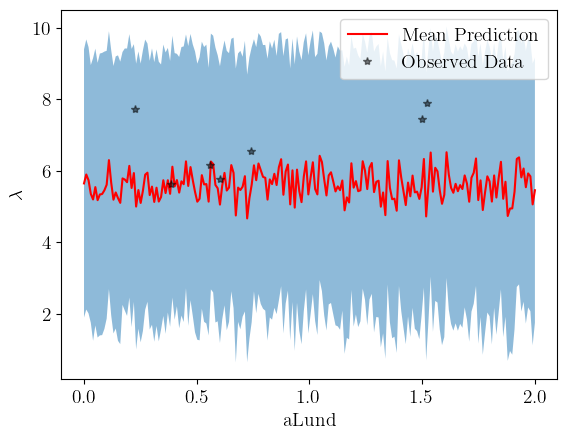

In [282]:
plot_model_param(model, 'aLund')

In [227]:
def get_observed_best_parameters(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    observed_min = train_x[train_y.argmin()]
    param_names = list(PARAM_DICT.keys())
    param_names = [param_name.split(':')[1] for param_name in param_names]
    best_params_dict = {k: v for k, v in zip(param_names, observed_min)}
    return best_params_dict

## Validate the results and observe the data-MC agreement is bad at this point

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [228]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))
        f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactC"]))
        f.write("StringZ:rFactB = {}\n\n".format(best_parameters["rFactB"]))
        f.write("StringZ:aExtraSQuark = {}\n\n".format(best_parameters["aExtraSQuark"]))
        f.write("StringZ:aExtraDiquark = {}\n\n".format(best_parameters["aExtraDiquark"]))
        f.write("StringPT:sigma = {}\n\n".format(best_parameters["sigma"]))
        f.write("StringPT:enhancedFraction = {}\n\n".format(best_parameters["enhancedFraction"]))
        f.write("StringPT:enhancedWidth = {}\n\n".format(best_parameters["enhancedWidth"]))
        f.write("StringFlav:ProbStoUD = {}\n\n".format(best_parameters["ProbStoUD"]))
        f.write("StringFlav:probQQtoQ = {}\n\n".format(best_parameters["probQQtoQ"]))
        f.write("StringFlav:probSQtoQQ = {}\n\n".format(best_parameters["probSQtoQQ"]))
        f.write("StringFlav:ProbQQ1toQQ0 = {}\n\n".format(best_parameters["ProbQQ1toQQ0"]))
        f.write("TimeShower:alphaSvalue = {}\n\n".format(best_parameters["alphaSvalue"]))
        f.write("TimeShower:pTmin = {}\n\n".format(best_parameters["pTmin"]))
def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

----

# Bayesian Optimization

Bayesian optimization is the optimization of a complex black box function (such as an objective function) $f(x)$ through iterative pointwise queries. The objective function is expensive, so it cannot be exhaustively evaluated. The function is also noisy, so repeated queries may yield different results.

We wish to find an optimal set of parameters $\mathbf{x}^*$ of the objective function

$$ \mathbf{x}^* = \text{arg max}_{\mathbf{x}\in \mathcal{R}^D} f(\mathbf{x})$$

In a nutshell, the algorithm works by forming a surrogate model $\hat{f}(x)$ by a GP of the objective function $f(x)$. 
$$ \hat{f}(\mathbf{x}) \sim \text{GP} (m(\mathbf{x}), k(\mathbf{x}))$$

We choose the next point through an acquisition function. We then evaluate and update the model, and repeat.

1. Construct a GP surrogate (regression) model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function $\alpha(x)$
$$
x_{new} = \arg\max\limits_x \alpha(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration** 

In [229]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
        return ei


In [283]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates)
next_x = x_candidates[0]
a = torch.cat([train_x, next_x.unsqueeze(0)])
print(a)

tensor([[0.9328, 0.8522, 0.1270, 0.0351, 1.6378, 0.9221, 0.8104, 0.3145, 3.5090,
         3.3686, 0.3537, 0.0456, 1.1403, 0.2009, 1.2236],
        [1.2235, 1.9919, 1.4995, 1.8863, 0.5952, 1.8290, 0.0401, 0.3057, 1.3191,
         3.0363, 3.8224, 0.1196, 3.2081, 0.2340, 1.6241]], dtype=torch.float64)
tensor([[0.3847, 1.2477, 0.1934, 1.9360, 1.3148, 1.0779, 0.9436, 0.9316, 3.5823,
         1.6980, 3.6605, 1.5323, 2.1654, 0.2073, 1.5966],
        [0.5588, 1.0878, 0.8160, 1.5550, 1.8498, 0.5195, 0.9612, 0.9664, 3.7693,
         1.4510, 2.9147, 0.5572, 2.9496, 0.1977, 1.4282],
        [0.7389, 1.2623, 0.7108, 0.1272, 1.7630, 1.1332, 0.8248, 0.9874, 3.7733,
         1.7727, 0.7961, 2.3526, 2.2570, 0.2285, 0.3529],
        [0.2251, 1.3746, 0.3742, 0.3128, 1.7786, 0.3958, 0.8746, 0.9995, 3.9384,
         2.4748, 0.3989, 2.7018, 3.4526, 0.1081, 0.1216],
        [1.4995, 1.5390, 0.6748, 1.8491, 1.0289, 0.4986, 0.9323, 0.9446, 3.4323,
         1.1603, 1.7350, 2.4089, 3.4972, 0.1887, 1.6385],
     

In [284]:
def BayesOpt_all_params(model, 
                        train_x, 
                        train_y, 
                        n_iterations, 
                        retrain_gp=False,
                        print_=False,
                       save_model=False):
    # Use the Adam optimizer

    model.eval()
    likelihood.eval()
    
    Monash_candidate = torch.tensor(list(MONASH_DICT.values()))
    next_y = true_objective_func(*Monash_candidate)
    print(f'objective function at the Monash point = {next_y}')
    train_x = torch.cat([train_x, Monash_candidate.unsqueeze(0)])
    next_y = torch.tensor([next_y])
    train_y = torch.cat([train_y, next_y])
    model.set_train_data(inputs=train_x, targets=train_y, strict=False)
    train_model(model, train_x, train_y, 25, print_=print_)
    
    for iteration in range(n_iterations):

        x_candidates = make_x_candidates(PARAM_DICT,1000)
        ei = expected_improvement(model, train_y, x_candidates)
        ei_argmax = ei.argmax()
        next_x = x_candidates[ei_argmax]
        next_y = true_objective_func(*next_x)
        train_x = torch.cat([train_x, next_x.unsqueeze(0)])
        next_y = torch.tensor([next_y])

        print(f'epoch {iteration} next_x = {next_x}, next_y = {next_y}')
        train_y = torch.cat([train_y, next_y])

        model.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # retrain model with updated data
        if retrain_gp:
            model.train()
            train_model(model, train_x, train_y, 50, print_=print_)

    train_size=train_x.shape[0]
    if save_model:
        path = f'models/GPytorch_all_params_model_Niter_{n_iterations}_trainsize_{train_size}.pth'
        torch.save(model.state_dict(), path)
        
        

In [285]:
BayesOpt_all_params(model, 
                    train_x, 
                    train_y, 
                    75, 
                    retrain_gp=True,
                    print_=False,
                   save_model=False)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:32:06
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:32:08
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:32:08, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00, 10.00it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.72it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.28  0.9024  0.036200  0.025764       141.0
1  0.005  0.010  22.16  1.7728  0.164487  0.253244       277.0
2  0.010  0.015  20.08  1.6064  0.251399  0.636486       251.0
3  0.015  0.020  18.32  1.4656  0.319957  1.124487       229.0
4  0.020  0.025  14.48  1.1584  0.320102  1.420936       181.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:32:15
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:32:18
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:32:18, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.62it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  28.32  2.2656  0.089453  0.064210       354.0
1  0.005  0.010  31.84  2.5472  0.234874  0.359894       398.0
2  0.010  0.015  27.84  2.2272  0.346899  0.876506       348.0
3  0.015  0.020  18.00  1.4400  0.312400  1.092125       225.0
4  0.020  0.025  12.96  1.0368  0.291312  1.315036       162.0
 new data keys ['/REF/ALEPH_1996_S3486095/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:32:24
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:32:27
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:32:27, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.63it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.34it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.40  0.0320  0.001474  0.001134         5.0
1  0.005  0.010  1.68  0.1344  0.013006  0.020796        21.0
2  0.010  0.015  4.08  0.3264  0.052564  0.136832        51.0
3  0.015  0.020  4.48  0.3584  0.080291  0.289859        56.0
4  0.020  0.025  5.04  0.4032  0.114059  0.518016        63.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/AL

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:32:33
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:32:36
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:32:36, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.89it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.80  0.0640  0.002602  0.001788        10.0
1  0.005  0.010  3.44  0.2752  0.025768  0.039876        43.0
2  0.010  0.015  7.20  0.5760  0.093094  0.243531        90.0
3  0.015  0.020  7.12  0.5696  0.125305  0.444237        89.0
4  0.020  0.025  8.16  0.6528  0.183865  0.831910       102.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:32:41
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:32:43
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:32:43, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.72it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.600000  0.9280  0.038922  0.029161       145.0
1  0.005  0.010  25.040001  2.0032  0.186962  0.289252       313.0
2  0.010  0.015  27.200001  2.1760  0.337926  0.851722       340.0
3  0.015  0.020  22.559999  1.8048  0.398087  1.413773       282.0
4  0.020  0.025  17.840000  1.4272  0.400472  1.805556       223.0
 new data keys ['/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:32:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:32:50
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:32:50, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.02it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.18it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  81.680000  6.5344  0.180924  0.105712      1021.0
1  0.005  0.010  29.920000  2.3936  0.217327  0.328764       374.0
2  0.010  0.015  17.280001  1.3824  0.209568  0.515227       216.0
3  0.015  0.020  12.080000  0.9664  0.207306  0.715781       151.0
4  0.020  0.025   8.080000  0.6464  0.184279  0.843415       101.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:32:55
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:32:58
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:32:58, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.75it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.92  0.3136  0.013352  0.010093        49.0
1  0.005  0.010   9.36  0.7488  0.070664  0.110900       117.0
2  0.010  0.015  10.08  0.8064  0.127038  0.324827       126.0
3  0.015  0.020  13.12  1.0496  0.228402  0.800673       164.0
4  0.020  0.025   9.52  0.7616  0.214968  0.974462       119.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:33:03
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:33:06
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:33:06, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.15it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.520000  0.9216  0.041301  0.032257       144.0
1  0.005  0.010  23.200001  1.8560  0.173835  0.270192       290.0
2  0.010  0.015  23.440001  1.8752  0.292400  0.738721       293.0
3  0.015  0.020  17.360001  1.3888  0.300942  1.050227       217.0
4  0.020  0.025  13.680000  1.0944  0.309221  1.403607       171.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:33:12
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:02 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:03 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:04 elapsed)
Event 2500 (0:00:04 elapsed)
Finished event loop at 2024-06-27 22:33:16
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:33:16, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.51it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.74it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.56  0.0448  0.001922  0.001474         7.0
1  0.005  0.010  1.60  0.1280  0.012296  0.019535        20.0
2  0.010  0.015  2.96  0.2368  0.038434  0.101144        37.0
3  0.015  0.020  4.96  0.3968  0.087162  0.308136        62.0
4  0.020  0.025  5.20  0.4160  0.117797  0.536412        65.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/AL

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:33:22
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:33:25
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:33:25, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.10it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.56  0.0448  0.002007  0.001491         7.0
1  0.005  0.010   5.44  0.4352  0.043439  0.071376        68.0
2  0.010  0.015   8.64  0.6912  0.108807  0.277661       108.0
3  0.015  0.020  10.16  0.8128  0.175067  0.606883       127.0
4  0.020  0.025  11.12  0.8896  0.247934  1.109840       139.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:33:30
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:33:32
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:33:32, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  47.119999  3.7696  0.115836  0.071882       589.0
1  0.005  0.010  26.080000  2.0864  0.192778  0.296373       326.0
2  0.010  0.015  20.000000  1.6000  0.247284  0.620152       250.0
3  0.015  0.020  15.040000  1.2032  0.259882  0.904353       188.0
4  0.020  0.025  11.600000  0.9280  0.260637  1.176000       145.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:33:38
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:02 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:04 elapsed)
Finished event loop at 2024-06-27 22:33:42
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:33:42, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.21it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.08  0.1664  0.007579  0.005935        26.0
1  0.005  0.010  5.36  0.4288  0.039646  0.060667        67.0
2  0.010  0.015  7.20  0.5760  0.090991  0.232513        90.0
3  0.015  0.020  7.60  0.6080  0.134743  0.480663        95.0
4  0.020  0.025  9.28  0.7424  0.209660  0.951148       116.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:33:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:33:51
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:33:51, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.26it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.48  0.1984  0.009808  0.008019        31.0
1  0.005  0.010   9.76  0.7808  0.075983  0.122167       122.0
2  0.010  0.015  12.16  0.9728  0.152854  0.389021       152.0
3  0.015  0.020  12.24  0.9792  0.212356  0.741836       153.0
4  0.020  0.025  11.04  0.8832  0.250099  1.137983       138.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:33:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:33:59
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:33:59, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.84it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.480000  1.1584  0.053671  0.042416       181.0
1  0.005  0.010  31.120001  2.4896  0.232234  0.357840       389.0
2  0.010  0.015  28.559999  2.2848  0.353291  0.886659       357.0
3  0.015  0.020  22.320000  1.7856  0.388575  1.362217       279.0
4  0.020  0.025  14.480000  1.1584  0.323326  1.450072       181.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:34:04
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:34:06
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:34:06, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.63it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  43.439999  3.4752  0.113692  0.073459       543.0
1  0.005  0.010  31.200001  2.4960  0.231768  0.357086       390.0
2  0.010  0.015  19.760000  1.5808  0.241966  0.600738       247.0
3  0.015  0.020  13.600000  1.0880  0.235307  0.819811       170.0
4  0.020  0.025   8.880000  0.7104  0.198555  0.891146       111.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:34:13
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:04 elapsed)
Finished event loop at 2024-06-27 22:34:17
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:34:17, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.48it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.64it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.32  0.1856  0.008759  0.007054        29.0
1  0.005  0.010  12.48  0.9984  0.097301  0.156731       156.0
2  0.010  0.015  11.92  0.9536  0.150891  0.386972       149.0
3  0.015  0.020  13.20  1.0560  0.232582  0.825074       165.0
4  0.020  0.025  12.88  1.0304  0.290010  1.310949       161.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:34:23
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:34:26
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:34:27, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.23it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.48  0.3584  0.015748  0.012021        56.0
1  0.005  0.010  10.80  0.8640  0.082379  0.130199       135.0
2  0.010  0.015  12.80  1.0240  0.159168  0.401032       160.0
3  0.015  0.020  13.84  1.1072  0.241237  0.846847       173.0
4  0.020  0.025  11.04  0.8832  0.248686  1.125269       138.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:34:32
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:00 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:01 elapsed)
Event 2400 (0:00:01 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:34:34
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:34:34, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.57it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  15.52  1.2416  0.051771  0.038861       194.0
1  0.005  0.010  29.68  2.3744  0.224832  0.353635       371.0
2  0.010  0.015  28.32  2.2656  0.352542  0.888857       354.0
3  0.015  0.020  23.92  1.9136  0.412001  1.429873       299.0
4  0.020  0.025  14.24  1.1392  0.320707  1.450374       178.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:34:41
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:34:44
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:34:44, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.240000  0.6592  0.026684  0.019892       103.0
1  0.005  0.010  18.160000  1.4528  0.137228  0.214627       227.0
2  0.010  0.015  15.760000  1.2608  0.195761  0.493090       197.0
3  0.015  0.020  16.799999  1.3440  0.290762  1.012334       210.0
4  0.020  0.025  13.920000  1.1136  0.314152  1.424104       174.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:34:49
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:34:51
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:34:51, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.90it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.68it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.040000  1.0432  0.044901  0.034008       163.0
1  0.005  0.010  29.120001  2.3296  0.220136  0.344815       364.0
2  0.010  0.015  27.680000  2.2144  0.342498  0.858991       346.0
3  0.015  0.020  18.719999  1.4976  0.322567  1.118898       234.0
4  0.020  0.025  14.640000  1.1712  0.327745  1.473632       183.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:34:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:34:59
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:34:59, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.09it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.40  0.0320  0.001356  0.001117         5.0
1  0.005  0.010  1.44  0.1152  0.012235  0.021280        18.0
2  0.010  0.015  3.20  0.2560  0.039910  0.100498        40.0
3  0.015  0.020  3.04  0.2432  0.052958  0.185734        38.0
4  0.020  0.025  4.08  0.3264  0.091750  0.414278        51.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:35:05
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:35:08
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:35:08, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.65it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.96  0.0768  0.003582  0.002762        12.0
1  0.005  0.010  3.44  0.2752  0.027156  0.044064        43.0
2  0.010  0.015  5.04  0.4032  0.064151  0.165774        63.0
3  0.015  0.020  8.32  0.6656  0.146866  0.522023       104.0
4  0.020  0.025  7.36  0.5888  0.164810  0.740946        92.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x0

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:35:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-27 22:35:12
Cross-section = 4.011604e+04 pb
Rivet run completed at 2024-06-27 22:35:12, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.205882  1.621972  0.005256  0.002628         3.0
1  0.005  0.010  0.735294  0.540658  0.006713  0.012258         1.0
2  0.010  0.015  6.617648  4.865916  0.082799  0.209219         9.0
3  0.015  0.020  5.147058  3.784602  0.090687  0.320564         7.0
4  0.020  0.025  4.411764  3.243945  0.103120  0.483799         6.0
 new data ke

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:35:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:35:20
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:35:20, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.54it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.20  0.0960  0.003995  0.002966        15.0
1  0.005  0.010  3.60  0.2880  0.029248  0.048637        45.0
2  0.010  0.015  7.20  0.5760  0.090500  0.230772        90.0
3  0.015  0.020  8.00  0.6400  0.140841  0.499523       100.0
4  0.020  0.025  8.96  0.7168  0.201772  0.912697       112.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x0

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:35:26
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:35:29
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:35:29, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.05it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.02it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.320000  0.5056  0.021776  0.016818        79.0
1  0.005  0.010  18.000000  1.4400  0.138722  0.221272       225.0
2  0.010  0.015  17.360001  1.3888  0.213033  0.529430       217.0
3  0.015  0.020  15.520000  1.2416  0.269754  0.944642       194.0
4  0.020  0.025  12.160000  0.9728  0.273715  1.237237       152.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:35:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:35:38
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:35:38, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.32  0.0256  0.000832  0.000521         4.0
1  0.005  0.010  1.60  0.1280  0.012409  0.020216        20.0
2  0.010  0.015  2.32  0.1856  0.028692  0.072173        29.0
3  0.015  0.020  3.12  0.2496  0.055476  0.198883        39.0
4  0.020  0.025  3.84  0.3072  0.088020  0.405017        48.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:35:44
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:35:46
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:35:46, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.16it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  19.120001  1.5296  0.057834  0.040104       239.0
1  0.005  0.010  26.639999  2.1312  0.198548  0.305816       333.0
2  0.010  0.015  21.600000  1.7280  0.267479  0.671628       270.0
3  0.015  0.020  16.000000  1.2800  0.277380  0.968620       200.0
4  0.020  0.025  12.480000  0.9984  0.278907  1.251107       156.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:35:52
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:35:55
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:35:55, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.20  0.4160  0.018149  0.013771        65.0
1  0.005  0.010  12.96  1.0368  0.096392  0.148811       162.0
2  0.010  0.015  14.40  1.1520  0.180262  0.457545       180.0
3  0.015  0.020  13.84  1.1072  0.240619  0.843001       173.0
4  0.020  0.025  13.20  1.0560  0.296963  1.341504       165.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:36:01
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:36:04
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:36:04, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.64it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.080000  0.6464  0.028243  0.021735       101.0
1  0.005  0.010  20.000000  1.6000  0.147233  0.224983       250.0
2  0.010  0.015  17.120001  1.3696  0.213228  0.537927       214.0
3  0.015  0.020  17.040001  1.3632  0.298142  1.050198       213.0
4  0.020  0.025  13.440000  1.0752  0.301845  1.361659       168.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:36:10
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:36:13
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:36:13, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.94it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.00  0.0000  0.000000  0.000000         0.0
1  0.005  0.010  0.96  0.0768  0.007633  0.012512        12.0
2  0.010  0.015  2.72  0.2176  0.033529  0.083680        34.0
3  0.015  0.020  3.84  0.3072  0.068676  0.246991        48.0
4  0.020  0.025  6.48  0.5184  0.146129  0.661421        81.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/AL

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:36:19
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:36:22
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:36:22, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  7.47it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.83it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.04  0.4032  0.016545  0.011970        63.0
1  0.005  0.010  11.84  0.9472  0.090031  0.141950       148.0
2  0.010  0.015  14.08  1.1264  0.177996  0.455918       176.0
3  0.015  0.020  12.96  1.0368  0.225562  0.790754       162.0
4  0.020  0.025  10.88  0.8704  0.245248  1.110736       136.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:36:28
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:36:30
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:36:30, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.34it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.99it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  33.040001  2.6432  0.093194  0.062651       413.0
1  0.005  0.010  29.520000  2.3616  0.218572  0.336597       369.0
2  0.010  0.015  19.120001  1.5296  0.239240  0.607218       239.0
3  0.015  0.020  15.760000  1.2608  0.273814  0.958388       197.0
4  0.020  0.025  10.880000  0.8704  0.244698  1.105498       136.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:36:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:36:39
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:36:39, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.20it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.63it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  28.080000  2.2464  0.084619  0.058599       351.0
1  0.005  0.010  29.760000  2.3808  0.216995  0.329248       372.0
2  0.010  0.015  21.440001  1.7152  0.263807  0.657737       268.0
3  0.015  0.020  16.879999  1.3504  0.295084  1.038570       211.0
4  0.020  0.025  11.280000  0.9024  0.253771  1.146693       141.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:36:45
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:36:47
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:36:47, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.13it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  21.76  1.7408  0.071263  0.051753       272.0
1  0.005  0.010  32.16  2.5728  0.237763  0.364483       402.0
2  0.010  0.015  24.40  1.9520  0.299320  0.744651       305.0
3  0.015  0.020  17.60  1.4080  0.305150  1.065526       220.0
4  0.020  0.025  14.56  1.1648  0.324630  1.452821       182.0
 new data keys ['/REF/ALEPH_1996_S3486095/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:36:53
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:36:55
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:36:55, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.28  0.2624  0.012842  0.010430        41.0
1  0.005  0.010  12.00  0.9600  0.092472  0.147516       150.0
2  0.010  0.015  15.76  1.2608  0.198464  0.506279       197.0
3  0.015  0.020  14.96  1.1968  0.261824  0.922554       187.0
4  0.020  0.025  13.68  1.0944  0.307142  1.384263       171.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:37:01
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:37:03
Cross-section = 4.141025e+04 pb
Rivet run completed at 2024-06-27 22:37:03, time elapsed = 0:00:02
Histograms written to 





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.05it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.73it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.615384  0.770464  0.027655  0.020246       120.0
1  0.005  0.010  11.698718  0.937397  0.089453  0.142388       146.0
2  0.010  0.015  13.942308  1.117172  0.172823  0.434422       174.0
3  0.015  0.020  16.185898  1.296947  0.280358  0.977337       202.0
4  0.020  0.025  11.939102  0.956659  0.265383  1.184822       149.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:37:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:37:11
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:37:11, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.43it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.84it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.002400  0.480384  0.018442  0.013474        75.0
1  0.005  0.010   9.843938  0.787830  0.074960  0.118301       123.0
2  0.010  0.015  12.565026  1.005604  0.156980  0.397819       157.0
3  0.015  0.020  12.965186  1.037630  0.226158  0.794594       162.0
4  0.020  0.025  13.765506  1.101681  0.311426  1.415027       172.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:37:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:37:19
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:37:19, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.08it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.480000  1.1584  0.044396  0.031534       181.0
1  0.005  0.010  19.280001  1.5424  0.145576  0.227926       241.0
2  0.010  0.015  18.160000  1.4528  0.225242  0.567360       227.0
3  0.015  0.020  13.040000  1.0432  0.224685  0.778678       163.0
4  0.020  0.025  12.720000  1.0176  0.283811  1.271860       159.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:37:25
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:02 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:04 elapsed)
Finished event loop at 2024-06-27 22:37:29
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:37:29, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.81it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.65it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.68  0.4544  0.019783  0.015257        71.0
1  0.005  0.010  14.48  1.1584  0.110613  0.175015       181.0
2  0.010  0.015  14.64  1.1712  0.181618  0.457593       183.0
3  0.015  0.020  15.12  1.2096  0.263186  0.922534       189.0
4  0.020  0.025  12.64  1.0112  0.284766  1.287970       158.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:37:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:37:37
Cross-section = 4.139368e+04 pb
Rivet run completed at 2024-06-27 22:37:37, time elapsed = 0:00:02
Histograms written to 





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.82it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  18.036072  1.445777  0.047445  0.032777       225.0
1  0.005  0.010  25.090179  2.011237  0.185993  0.285107       313.0
2  0.010  0.015  18.436874  1.477906  0.229670  0.579444       230.0
3  0.015  0.020  18.436874  1.477906  0.317877  1.103452       230.0
4  0.020  0.025  14.108216  1.130919  0.317652  1.436089       176.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:37:43
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:37:45
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:37:45, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.51it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.80  0.7040  0.027717  0.020296       110.0
1  0.005  0.010  14.24  1.1392  0.105888  0.163497       178.0
2  0.010  0.015  18.48  1.4784  0.229251  0.576676       231.0
3  0.015  0.020  13.20  1.0560  0.228816  0.798486       165.0
4  0.020  0.025  13.76  1.1008  0.309845  1.400966       172.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:37:51
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:37:53
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:37:53, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.01it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.85it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.200000  0.7360  0.031303  0.023321       115.0
1  0.005  0.010  17.520000  1.4016  0.131064  0.204171       219.0
2  0.010  0.015  16.799999  1.3440  0.208447  0.523951       210.0
3  0.015  0.020  16.000000  1.2800  0.279728  0.984945       200.0
4  0.020  0.025  12.720000  1.0176  0.284412  1.276701       159.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:37:59
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:38:01
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:38:01, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  41.279999  3.3024  0.128040  0.091330       516.0
1  0.005  0.010  47.680000  3.8144  0.350255  0.534398       596.0
2  0.010  0.015  27.920000  2.2336  0.344240  0.860022       349.0
3  0.015  0.020  18.480000  1.4784  0.319197  1.110891       231.0
4  0.020  0.025  11.440000  0.9152  0.254832  1.139637       143.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:38:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:38:11
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:38:11, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.71it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.89it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.56  0.0448  0.001944  0.001399         7.0
1  0.005  0.010  1.60  0.1280  0.013028  0.021811        20.0
2  0.010  0.015  3.44  0.2752  0.043372  0.110781        43.0
3  0.015  0.020  3.52  0.2816  0.061222  0.214521        44.0
4  0.020  0.025  4.00  0.3200  0.090661  0.412802        50.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/AL

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:38:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:01 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:38:19
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:38:19, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  7.59it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.89it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.92  0.7936  0.028233  0.020407       124.0
1  0.005  0.010  14.32  1.1456  0.106508  0.163602       179.0
2  0.010  0.015  14.56  1.1648  0.181315  0.457878       182.0
3  0.015  0.020  15.20  1.2160  0.263774  0.921980       190.0
4  0.020  0.025  13.20  1.0560  0.294569  1.320206       165.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:38:25
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:02 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:03 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:04 elapsed)
Event 2400 (0:00:04 elapsed)
Event 2500 (0:00:04 elapsed)
Finished event loop at 2024-06-27 22:38:29
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:38:29, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.38it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.11it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.40  0.6720  0.028068  0.021057       105.0
1  0.005  0.010  17.76  1.4208  0.133301  0.207696       222.0
2  0.010  0.015  19.84  1.5872  0.249040  0.633898       248.0
3  0.015  0.020  16.32  1.3056  0.286280  1.010626       204.0
4  0.020  0.025  13.44  1.0752  0.299736  1.341979       168.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:38:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:38:36
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:38:36, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.320000  1.1456  0.045253  0.033124       179.0
1  0.005  0.010  20.719999  1.6576  0.157272  0.247162       259.0
2  0.010  0.015  20.959999  1.6768  0.261800  0.663056       262.0
3  0.015  0.020  14.240000  1.1392  0.247847  0.868680       178.0
4  0.020  0.025  10.480000  0.8384  0.234557  1.054325       131.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:38:41
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:38:43
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:38:43, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  34.720001  2.7776  0.097723  0.066288       434.0
1  0.005  0.010  30.320000  2.4256  0.220333  0.332345       379.0
2  0.010  0.015  21.600000  1.7280  0.265475  0.660919       270.0
3  0.015  0.020  17.280001  1.3824  0.302692  1.067638       216.0
4  0.020  0.025  11.440000  0.9152  0.257163  1.160310       143.0
 new data keys ['/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:38:49
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:38:51
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:38:51, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.28  0.1024  0.003614  0.002292        16.0
1  0.005  0.010  4.08  0.3264  0.030518  0.047192        51.0
2  0.010  0.015  5.76  0.4608  0.072952  0.186764        72.0
3  0.015  0.020  6.24  0.4992  0.110035  0.390205        78.0
4  0.020  0.025  8.56  0.6848  0.191187  0.857506       107.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/AL

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:38:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:39:00
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:39:00, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   3.44  0.2752  0.013176  0.010504        43.0
1  0.005  0.010  10.88  0.8704  0.083623  0.133535       136.0
2  0.010  0.015  13.36  1.0688  0.167039  0.422815       167.0
3  0.015  0.020  13.12  1.0496  0.229285  0.807140       164.0
4  0.020  0.025  12.08  0.9664  0.270987  1.220488       151.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:39:06
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:39:09
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:39:09, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.48it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.40  0.0320  0.001600  0.001310         5.0
1  0.005  0.010  1.28  0.1024  0.010049  0.016339        16.0
2  0.010  0.015  3.12  0.2496  0.038783  0.097760        39.0
3  0.015  0.020  6.40  0.5120  0.111516  0.391303        80.0
4  0.020  0.025  6.08  0.4864  0.137593  0.625211        76.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/AL

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:39:15
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:39:18
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:39:18, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.13it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.77it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.64  0.3712  0.016796  0.013283        58.0
1  0.005  0.010  12.00  0.9600  0.090309  0.140678       150.0
2  0.010  0.015  13.84  1.1072  0.171859  0.432536       173.0
3  0.015  0.020  15.04  1.2032  0.261570  0.915442       188.0
4  0.020  0.025  12.40  0.9920  0.278127  1.253017       155.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:39:23
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:39:25
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:39:25, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.81it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.74it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.720000  1.1776  0.046285  0.033828       184.0
1  0.005  0.010  24.400000  1.9520  0.186593  0.295194       305.0
2  0.010  0.015  21.360001  1.7088  0.264590  0.663841       267.0
3  0.015  0.020  19.840000  1.5872  0.344080  1.201202       248.0
4  0.020  0.025  13.760000  1.1008  0.308121  1.386218       172.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:39:30
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:39:32
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:39:32, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  35.279999  2.8224  0.116754  0.085746       441.0
1  0.005  0.010  47.439999  3.7952  0.344766  0.520384       593.0
2  0.010  0.015  28.799999  2.3040  0.357861  0.900921       360.0
3  0.015  0.020  19.040001  1.5232  0.329263  1.147107       238.0
4  0.020  0.025  10.800000  0.8640  0.240309  1.073626       135.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:39:37
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:39:39
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:39:39, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.65it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.65it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  25.850340  2.068855  0.075908  0.052276       323.0
1  0.005  0.010  32.252899  2.581264  0.237738  0.364665       403.0
2  0.010  0.015  19.847940  1.588470  0.245451  0.614774       248.0
3  0.015  0.020  19.207684  1.537230  0.330869  1.147519       240.0
4  0.020  0.025  14.485794  1.159327  0.323647  1.452224       181.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:39:44
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:39:46
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:39:46, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.03it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.760000  0.9408  0.036537  0.025872       147.0
1  0.005  0.010  16.639999  1.3312  0.121502  0.184151       208.0
2  0.010  0.015  15.040000  1.2032  0.189091  0.481556       188.0
3  0.015  0.020  14.000000  1.1200  0.243850  0.855237       175.0
4  0.020  0.025  12.640000  1.0112  0.282164  1.265534       158.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:39:52
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:39:55
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:39:55, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.44it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  16.400000  1.3120  0.055748  0.042110       205.0
1  0.005  0.010  27.120001  2.1696  0.200175  0.305989       339.0
2  0.010  0.015  21.760000  1.7408  0.269300  0.676059       272.0
3  0.015  0.020  20.240000  1.6192  0.353740  1.244056       253.0
4  0.020  0.025  11.280000  0.9024  0.253761  1.146344       141.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:40:00
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:40:02
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:40:02, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.84it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.18it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.000000  0.6400  0.026041  0.019055       100.0
1  0.005  0.010  19.200001  1.5360  0.144563  0.225101       240.0
2  0.010  0.015  20.000000  1.6000  0.249033  0.628286       250.0
3  0.015  0.020  18.559999  1.4848  0.324933  1.145401       232.0
4  0.020  0.025  15.600000  1.2480  0.350058  1.577794       195.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:40:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:40:11
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:40:11, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.20  0.0960  0.002892  0.002015        15.0
1  0.005  0.010  2.40  0.1920  0.017941  0.027712        30.0
2  0.010  0.015  3.28  0.2624  0.041691  0.107584        41.0
3  0.015  0.020  4.16  0.3328  0.073405  0.260984        52.0
4  0.020  0.025  4.72  0.3776  0.104772  0.466900        59.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/AL

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:40:18
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:40:21
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:40:21, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  7.85it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.15it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.32  0.0256  0.001017  0.000657         4.0
1  0.005  0.010  0.80  0.0640  0.005824  0.008645        10.0
2  0.010  0.015  1.44  0.1152  0.018036  0.045871        18.0
3  0.015  0.020  2.48  0.1984  0.043821  0.155861        31.0
4  0.020  0.025  2.40  0.1920  0.053823  0.242470        30.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/AL

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:40:26
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:40:28
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:40:28, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.42it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  18.160000  1.4528  0.055309  0.039142       227.0
1  0.005  0.010  19.920000  1.5936  0.144203  0.216734       249.0
2  0.010  0.015  16.879999  1.3504  0.207470  0.516775       211.0
3  0.015  0.020  16.639999  1.3312  0.289677  1.015871       208.0
4  0.020  0.025  13.200000  1.0560  0.294801  1.322005       165.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:40:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:40:37
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:40:37, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.15it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.16  0.1728  0.007644  0.005854        27.0
1  0.005  0.010   5.84  0.4672  0.045722  0.074202        73.0
2  0.010  0.015  11.12  0.8896  0.138771  0.351342       139.0
3  0.015  0.020  13.68  1.0944  0.239888  0.846604       171.0
4  0.020  0.025  14.64  1.1712  0.329262  1.486695       183.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:40:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:40:44
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:40:44, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.47it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.40  0.6720  0.029337  0.022468       105.0
1  0.005  0.010  14.88  1.1904  0.112329  0.175789       186.0
2  0.010  0.015  21.60  1.7280  0.267715  0.673359       270.0
3  0.015  0.020  18.48  1.4784  0.323465  1.140620       231.0
4  0.020  0.025  14.88  1.1904  0.331582  1.484472       186.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:40:49
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:40:51
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:40:51, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.76it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.320000  0.8256  0.033820  0.024399       129.0
1  0.005  0.010  22.719999  1.8176  0.171582  0.268713       284.0
2  0.010  0.015  20.559999  1.6448  0.251253  0.621648       257.0
3  0.015  0.020  17.120001  1.3696  0.299407  1.053771       214.0
4  0.020  0.025  15.440000  1.2352  0.347144  1.567604       193.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:40:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:40:59
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:40:59, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.99it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  29.280001  2.3424  0.077413  0.049883       366.0
1  0.005  0.010  27.360001  2.1888  0.205243  0.318886       342.0
2  0.010  0.015  17.600000  1.4080  0.219477  0.554922       220.0
3  0.015  0.020  15.280000  1.2224  0.266748  0.938225       191.0
4  0.020  0.025  11.600000  0.9280  0.261549  1.184174       145.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:41:04
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:41:06
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:41:06, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.82it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  32.240002  2.5792  0.093745  0.064384       403.0
1  0.005  0.010  27.200001  2.1760  0.199347  0.303877       340.0
2  0.010  0.015  19.600000  1.5680  0.244929  0.620094       245.0
3  0.015  0.020  16.080000  1.2864  0.279774  0.980442       201.0
4  0.020  0.025  12.880000  1.0304  0.289358  1.305761       161.0
 new data keys ['/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:41:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:41:14
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:41:14, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.40it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.99it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  48.160000  3.8528  0.145204  0.100076       602.0
1  0.005  0.010  34.799999  2.7840  0.252957  0.382211       435.0
2  0.010  0.015  21.520000  1.7216  0.267641  0.674340       269.0
3  0.015  0.020  14.000000  1.1200  0.243162  0.850518       175.0
4  0.020  0.025  12.640000  1.0112  0.280333  1.248474       158.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:41:19
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:41:21
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:41:21, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.13it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  21.600000  1.7280  0.068275  0.049022       270.0
1  0.005  0.010  27.040001  2.1632  0.199130  0.304244       338.0
2  0.010  0.015  23.040001  1.8432  0.287008  0.724453       288.0
3  0.015  0.020  16.080000  1.2864  0.280754  0.986989       201.0
4  0.020  0.025  12.880000  1.0304  0.286204  1.276601       161.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:41:26
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:41:29
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:41:29, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.22it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.960000  0.5568  0.023068  0.017114        87.0
1  0.005  0.010  17.360001  1.3888  0.133798  0.213593       217.0
2  0.010  0.015  18.639999  1.4912  0.232695  0.589567       233.0
3  0.015  0.020  17.280001  1.3824  0.300264  1.050752       216.0
4  0.020  0.025  12.000000  0.9600  0.270023  1.220287       150.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:41:34
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:41:37
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:41:37, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.14it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.13it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  51.360001  4.1088  0.147517  0.099117       642.0
1  0.005  0.010  39.759998  3.1808  0.288370  0.435608       497.0
2  0.010  0.015  23.760000  1.9008  0.295588  0.745138       297.0
3  0.015  0.020  15.120000  1.2096  0.262190  0.915131       189.0
4  0.020  0.025  10.000000  0.8000  0.221100  0.982188       125.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:41:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:41:44
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:41:44, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.08  0.6464  0.026657  0.019706       101.0
1  0.005  0.010  16.32  1.3056  0.122979  0.192298       204.0
2  0.010  0.015  14.24  1.1392  0.175113  0.436266       178.0
3  0.015  0.020  14.08  1.1264  0.247852  0.878281       176.0
4  0.020  0.025  11.12  0.8896  0.250215  1.130787       139.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:41:50
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:41:52
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:41:52, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.65it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.70it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  17.360001  1.3888  0.054108  0.038881       217.0
1  0.005  0.010  26.799999  2.1440  0.196161  0.298067       335.0
2  0.010  0.015  20.959999  1.6768  0.260233  0.655527       262.0
3  0.015  0.020  16.000000  1.2800  0.277950  0.971850       200.0
4  0.020  0.025  12.560000  1.0048  0.280217  1.255783       157.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:41:59
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:42:02
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:42:02, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.98it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.56  0.3648  0.016168  0.012599        57.0
1  0.005  0.010  16.40  1.3120  0.126220  0.201199       205.0
2  0.010  0.015  16.24  1.2992  0.204153  0.520755       203.0
3  0.015  0.020  15.76  1.2608  0.276171  0.974439       197.0
4  0.020  0.025  12.72  1.0176  0.287892  1.308382       159.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:42:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 22:42:12
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:42:12, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.03it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.440000  1.0752  0.045808  0.034353       168.0
1  0.005  0.010  25.680000  2.0544  0.198941  0.318531       321.0
2  0.010  0.015  18.320000  1.4656  0.227376  0.572656       229.0
3  0.015  0.020  16.799999  1.3440  0.291315  1.017585       210.0
4  0.020  0.025  15.360000  1.2288  0.343388  1.541341       192.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:42:18
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:42:20
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:42:20, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.45it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh   sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.32  0.1856  0.007921  0.005901        29.0
1  0.005  0.010   6.88  0.5504  0.052699  0.083090        86.0
2  0.010  0.015  11.92  0.9536  0.150263  0.383753       149.0
3  0.015  0.020  12.00  0.9600  0.211349  0.748879       150.0
4  0.020  0.025  10.88  0.8704  0.246834  1.124940       136.0
 new data keys ['/REF/ALEPH_1996_S3486095/

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 22:42:24
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Finished event loop at 2024-06-27 22:42:26
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 22:42:26, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.26it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.080000  0.6464  0.025453  0.018366       101.0
1  0.005  0.010  18.400000  1.4720  0.139098  0.217632       230.0
2  0.010  0.015  18.959999  1.5168  0.238141  0.604876       237.0
3  0.015  0.020  16.959999  1.3568  0.296534  1.043444       212.0
4  0.020  0.025  14.240000  1.1392  0.318282  1.428563       178.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

(200,)


/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


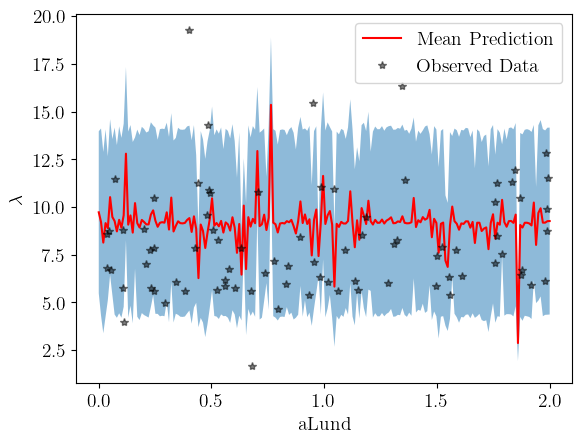

In [286]:
plot_model_param(model, 'aLund')

In [287]:
best_observed_params =get_observed_best_parameters(model)
best_observed_params

{'aLund': 0.6800000071525574,
 'bLund': 0.9800000190734863,
 'rFactC': 1.3200000524520874,
 'rFactB': 0.8550000190734863,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 0.9700000286102295,
 'sigma': 0.33500000834465027,
 'enhancedFraction': 0.009999999776482582,
 'enhancedWidth': 2.0,
 'ProbStoUD': 0.21699999272823334,
 'probQQtoQ': 0.08100000023841858,
 'probSQtoQQ': 0.9150000214576721,
 'ProbQQ1toQQ0': 0.027499999850988388,
 'alphaSvalue': 0.13650000095367432,
 'pTmin': 0.5}